# Loan Risk Prediction with Artificial Neural Networks

Data: LendingClub dataset from Kaggle: https://www.kaggle.com/wordsforthewise/lending-club

### Objective

Predict wether someone will pay back their loan based on historical information from the Lending Club dataset.

LendingClub is a US peer-to-peer lending company. Historical data on loans given out with information on whether or not the borrower defaulted (charge-off).

 Build a model that can predict wether or not a borrower will pay back their loan based on this data. New potential customer can be assessed for their risk of not paying back the loan.

The label is in the "loan_status" column.


In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

In [ ]:
!pip install tensorflow

In [3]:
from google.colab import files
uploaded = files.upload()
import io
df_info = pd.read_csv(io.BytesIO(uploaded['lending_club_info.csv']))

Saving lending_club_info.csv to lending_club_info.csv


In [4]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['lending_club_loan_two.csv']))

Saving lending_club_loan_two.csv to lending_club_loan_two.csv


In [6]:
df_info

,LoanStatNew,Description
0,loan_amnt,The listed amount of the loan applied for by t...
1,term,The number of payments on the loan. Values are...
2,int_rate,Interest Rate on the loan
3,installment,The monthly payment owed by the borrower if th...
4,grade,LC assigned loan grade
5,sub_grade,LC assigned loan subgrade
6,emp_title,The job title supplied by the Borrower when ap...
7,emp_length,Employment length in years. Possible values ar...
8,home_ownership,The home ownership status provided by the borr...
9,annual_inc,The self-reported annual income provided by th...


In [7]:
#helper function to access feature description

df_info = df_info.set_index('LoanStatNew')

def feat_info(col_name):
    print(df_info.loc[col_name]['Description'])

In [8]:
feat_info('mort_acc')

Number of mortgage accounts.


## EDA

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

In [10]:
df.head(5)

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\nGreggshire, VA 11650"


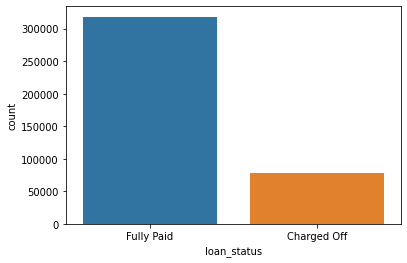

In [11]:
#countplot to explore balancing of labels
sns.countplot(x='loan_status',data=df)
#data imbalance

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


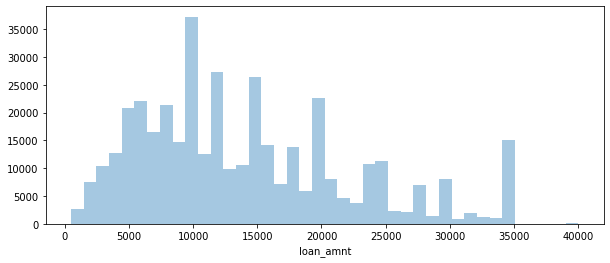

In [12]:
#histogram on loan_amnt
plt.figure(figsize=(10,4))
sns.distplot(df['loan_amnt'],kde=False,bins=40)
#spike at even money amount, these may be the standard loans

In [13]:
#explore corrleation between continuous feature variables
df.corr()

,loan_amnt,int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,pub_rec_bankruptcies
loan_amnt,1.000000,0.168921,0.953929,0.336887,0.016636,0.198556,-0.077779,0.328320,0.099911,0.223886,0.222315,-0.106539
int_rate,0.168921,1.000000,0.162758,-0.056771,0.079038,0.011649,0.060986,-0.011280,0.293659,-0.036404,-0.082583,0.057450
installment,0.953929,0.162758,1.000000,0.330381,0.015786,0.188973,-0.067892,0.316455,0.123915,0.202430,0.193694,-0.098628
annual_inc,0.336887,-0.056771,0.330381,1.000000,-0.081685,0.136150,-0.013720,0.299773,0.027871,0.193023,0.236320,-0.050162
dti,0.016636,0.079038,0.015786,-0.081685,1.000000,0.136181,-0.017639,0.063571,0.088375,0.102128,-0.025439,-0.014558
open_acc,0.198556,0.011649,0.188973,0.136150,0.136181,1.000000,-0.018392,0.221192,-0.131420,0.680728,0.109205,-0.027732
pub_rec,-0.077779,0.060986,-0.067892,-0.013720,-0.017639,-0.018392,1.000000,-0.101664,-0.075910,0.019723,0.011552,0.699408
revol_bal,0.328320,-0.011280,0.316455,0.299773,0.063571,0.221192,-0.101664,1.000000,0.226346,0.191616,0.194925,-0.124532
revol_util,0.099911,0.293659,0.123915,0.027871,0.088375,-0.131420,-0.075910,0.226346,1.000000,-0.104273,0.007514,-0.086751
total_acc,0.223886,-0.036404,0.202430,0.193023,0.102128,0.680728,0.019723,0.191616,-0.104273,1.000000,0.381072,0.042035


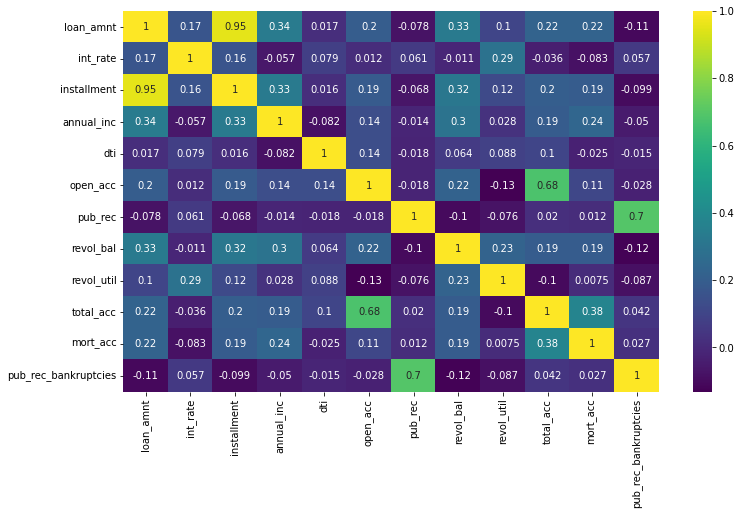

In [14]:
plt.figure(figsize=(12,7))
sns.heatmap(df.corr(),annot=True,cmap='viridis')

In [15]:
#high correlation between loan amount and installment
feat_info('installment')
#of course installment and loan amount are correlated -> multicollinearity

The monthly payment owed by the borrower if the loan originates.


Loan Amount

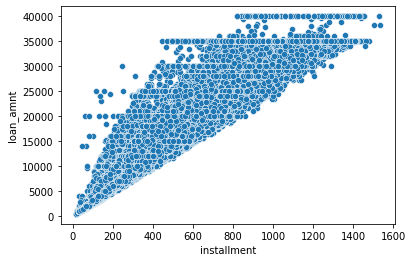

In [16]:
sns.scatterplot(x='installment',y='loan_amnt',data=df)

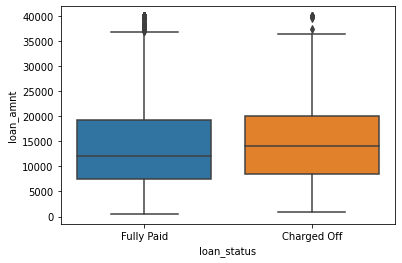

In [17]:
#relationship between loan_status (target variable) and loan_amnt
sns.boxplot(x='loan_status',y='loan_amnt',data=df)
#slightly higher chance that higher loans are paid back

In [18]:
df.groupby('loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


Grades

In [19]:
#explore grades and subgrades
df['grade'].unique()

array(['B', 'A', 'C', 'E', 'D', 'F', 'G'], dtype=object)

In [20]:
df['sub_grade'].unique()

array(['B4', 'B5', 'B3', 'A2', 'C5', 'C3', 'A1', 'B2', 'C1', 'A5', 'E4',
       'A4', 'A3', 'D1', 'C2', 'B1', 'D3', 'D5', 'D2', 'E1', 'E2', 'E5',
       'F4', 'E3', 'D4', 'G1', 'F5', 'G2', 'C4', 'F1', 'F3', 'G5', 'G4',
       'F2', 'G3'], dtype=object)

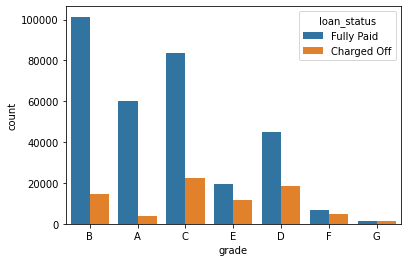

In [21]:
sns.countplot(x='grade',data=df,hue='loan_status')

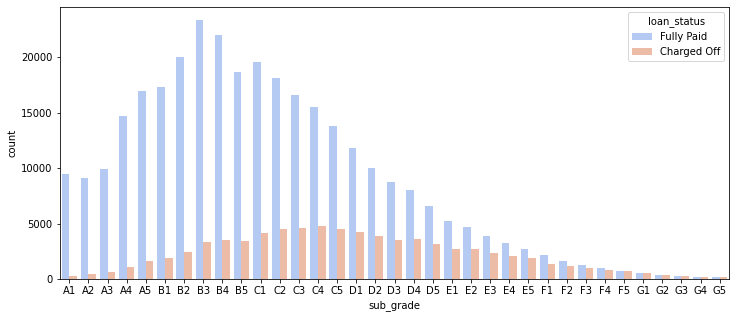

In [22]:
#countplot per subgrade
plt.figure(figsize=(12,5))
subgrade_order = sorted(df['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df,order=subgrade_order,palette='coolwarm',hue='loan_status')
#rating G and F amount of charged off loans equal to fully paid

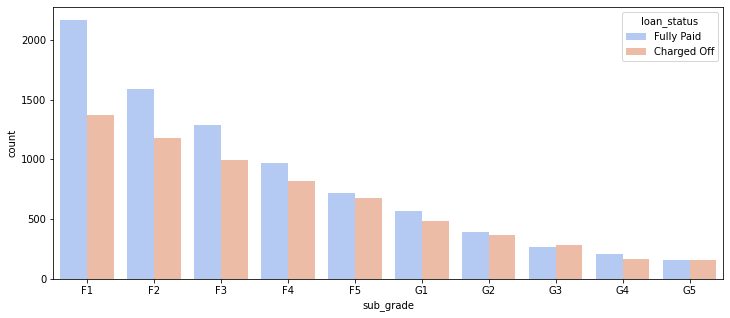

In [23]:
#explore F and G grades

f_and_g = df[(df['grade']=='G') | (df['grade']=='F')]

subgrade_order = sorted(f_and_g['sub_grade'].unique())


plt.figure(figsize=(12,5))
sns.countplot(x='sub_grade',data=f_and_g,palette='coolwarm',hue='loan_status',order=subgrade_order)

Feature Engineering: Loan Repaid

In [24]:
#one-hot-encode target variable loan_status
#better create new label column
df['loan_repaid'] = df['loan_status'].map({'Fully Paid': 1, 'Charged Off': 0})

df[['loan_repaid','loan_status']]

,loan_repaid,loan_status
0,1,Fully Paid
1,1,Fully Paid
2,1,Fully Paid
3,1,Fully Paid
4,0,Charged Off
...,...,...
396025,1,Fully Paid
396026,1,Fully Paid
396027,1,Fully Paid
396028,1,Fully Paid


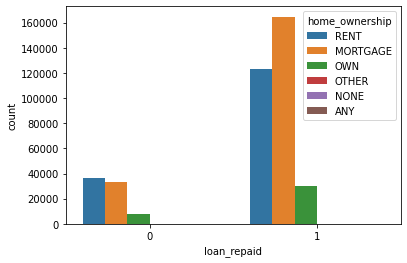

In [25]:
#explore more features
sns.countplot(x='loan_repaid',hue='home_ownership',data=df)

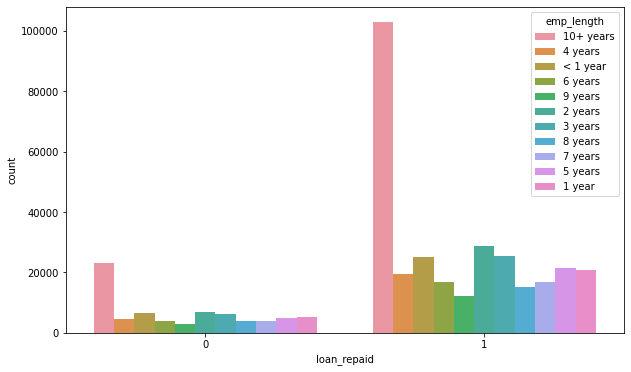

In [26]:
plt.figure(figsize=(10,6))
sns.countplot(x='loan_repaid',hue='emp_length',data=df)

Numeric Features

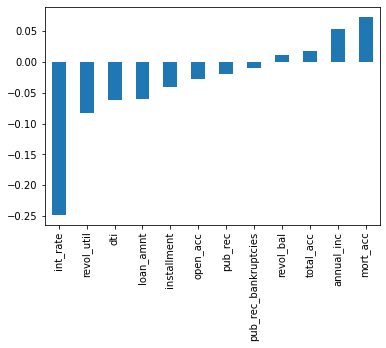

In [27]:
#look at numeric features and their correlation with the label

df.corr()['loan_repaid'].sort_values().drop('loan_repaid').plot(kind='bar')
#high interest rate negative correlation with paying off loan

In [28]:
df.groupby('loan_repaid')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_repaid,,,,,,,,
0,77673.0,67535.537710,58303.457136,0.0,42000.00,59000.0,80000.0,8706582.0
1,318357.0,75829.951566,62315.991907,600.0,46050.53,65000.0,90000.0,7600000.0


In [29]:
feat_info('mort_acc')

Number of mortgage accounts.


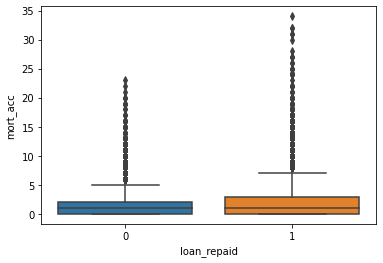

In [30]:
sns.boxplot(x='loan_repaid',y='mort_acc',data=df)

In [31]:
feat_info('pub_rec')

Number of derogatory public records


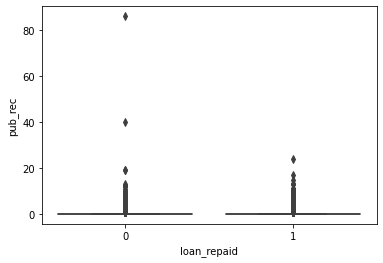

In [32]:
sns.boxplot(x='loan_repaid',y='pub_rec',data=df)

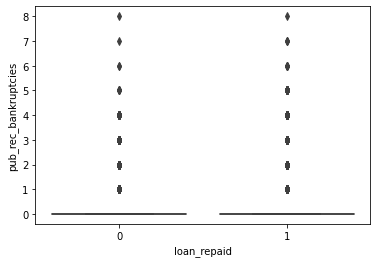

In [33]:
sns.boxplot(x='loan_repaid',y='pub_rec_bankruptcies',data=df)

In [34]:
df.groupby('loan_repaid')['pub_rec_bankruptcies'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_repaid,,,,,,,,
0,77586.0,0.128412,0.368853,0.0,0.0,0.0,0.0,8.0
1,317909.0,0.119997,0.352992,0.0,0.0,0.0,0.0,8.0


## Data Preprocessing

### Missing values

In [35]:
#checkout missing data
len(df)

396030

In [36]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
emp_title               22927
emp_length              18301
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [37]:
100 * df.isnull().sum() / len(df)
#mort_acc has almost 10% of data missing and needs to be filled, but some can just be dropped

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
installment             0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443148
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
loan_repaid             0.000000
dtype: float64

In [38]:
#emp_title and emp_length

df['emp_title'].nunique()
#too many features, better drop

173105

In [39]:
df = df.drop('emp_title',axis=1)

In [40]:
df['emp_length'].dropna().unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year'],
      dtype=object)

In [41]:
emp_length_order = ['10+ years', '9 years', '8 years', '7 years','6 years','5 years', '4 years', 
      '3 years', '2 years',  '1 year', '< 1 year',]

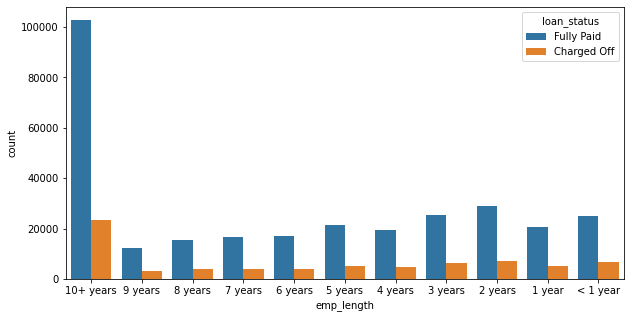

In [42]:
plt.figure(figsize=(10,5))
sns.countplot(x='emp_length',data=df,order=emp_length_order,hue='loan_status')

In [43]:
#would be better to have percent of people who don't pay back their loan per employmen category

emp_co = df[df['loan_status']=='Charged Off'].groupby('emp_length').count()['loan_status']

In [44]:
emp_fp = df[df['loan_status']=='Fully Paid'].groupby('emp_length').count()['loan_status']

In [45]:
emp_co/(emp_co+emp_fp)
#percent per category
#not much difference between categories

emp_length
1 year       0.199135
10+ years    0.184186
2 years      0.193262
3 years      0.195231
4 years      0.192385
5 years      0.192187
6 years      0.189194
7 years      0.194774
8 years      0.199760
9 years      0.200470
< 1 year     0.206872
Name: loan_status, dtype: float64

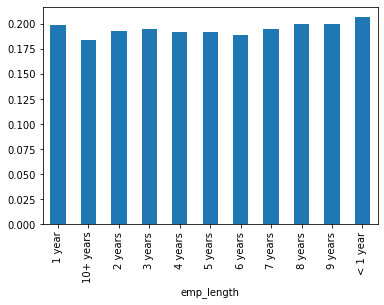

In [46]:
plot = emp_co/(emp_co+emp_fp)
plot.plot(kind='bar')

In [47]:
#no real difference, we can drop this column
df = df.drop('emp_length',axis=1)

In [48]:
df.isnull().sum()

loan_amnt                   0
term                        0
int_rate                    0
installment                 0
grade                       0
sub_grade                   0
home_ownership              0
annual_inc                  0
verification_status         0
issue_d                     0
loan_status                 0
purpose                     0
title                    1755
dti                         0
earliest_cr_line            0
open_acc                    0
pub_rec                     0
revol_bal                   0
revol_util                276
total_acc                   0
initial_list_status         0
application_type            0
mort_acc                37795
pub_rec_bankruptcies      535
address                     0
loan_repaid                 0
dtype: int64

In [49]:
#idea: substitue title with purpose
feat_info('purpose')

A category provided by the borrower for the loan request. 


In [50]:
df['purpose'].head()

0              vacation
1    debt_consolidation
2           credit_card
3           credit_card
4           credit_card
Name: purpose, dtype: object

In [51]:
df['title'].head()

0                   Vacation
1         Debt consolidation
2    Credit card refinancing
3    Credit card refinancing
4      Credit Card Refinance
Name: title, dtype: object

In [52]:
#drop title column
df = df.drop('title',axis=1)

In [53]:
#feature mort_acc
#almost 10% are missing here
feat_info('mort_acc')

Number of mortgage accounts.


In [54]:
df['mort_acc'].value_counts()

0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
23.0         2
32.0         2
26.0         2
31.0         2
30.0         1
28.0         1
34.0         1
Name: mort_acc, dtype: int64

In [55]:
#which feature correlates with mort_acc

df.corr()['mort_acc'].sort_values()
#correlated with total_acc feature

int_rate               -0.082583
dti                    -0.025439
revol_util              0.007514
pub_rec                 0.011552
pub_rec_bankruptcies    0.027239
loan_repaid             0.073111
open_acc                0.109205
installment             0.193694
revol_bal               0.194925
loan_amnt               0.222315
annual_inc              0.236320
total_acc               0.381072
mort_acc                1.000000
Name: mort_acc, dtype: float64

In [56]:
#group by total_acc and get mean value for mort_acc
#use average to fill in mort_acc

total_acc_avg = df.groupby('total_acc')['mort_acc'].mean()

In [57]:
def fill_mort_acc(total_acc,mort_acc):

  if np.isnan(mort_acc):
    return total_acc_avg[total_acc]
  else:
    return mort_acc


In [58]:
df['mort_acc'] = df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [59]:
df.isnull().sum()

loan_amnt                 0
term                      0
int_rate                  0
installment               0
grade                     0
sub_grade                 0
home_ownership            0
annual_inc                0
verification_status       0
issue_d                   0
loan_status               0
purpose                   0
dti                       0
earliest_cr_line          0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util              276
total_acc                 0
initial_list_status       0
application_type          0
mort_acc                  0
pub_rec_bankruptcies    535
address                   0
loan_repaid               0
dtype: int64

In [60]:
#what's left is so small that we can drop the rows

df = df.dropna()
df.isnull().sum()

loan_amnt               0
term                    0
int_rate                0
installment             0
grade                   0
sub_grade               0
home_ownership          0
annual_inc              0
verification_status     0
issue_d                 0
loan_status             0
purpose                 0
dti                     0
earliest_cr_line        0
open_acc                0
pub_rec                 0
revol_bal               0
revol_util              0
total_acc               0
initial_list_status     0
application_type        0
mort_acc                0
pub_rec_bankruptcies    0
address                 0
loan_repaid             0
dtype: int64

### Categorical and dummy variables

In [61]:
df.select_dtypes(['object']).columns
#we have to decide which are useful and one-hot-encode them and which to drop

Index(['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status',
       'issue_d', 'loan_status', 'purpose', 'earliest_cr_line',
       'initial_list_status', 'application_type', 'address'],
      dtype='object')

In [62]:
#term feature
feat_info('term')

The number of payments on the loan. Values are in months and can be either 36 or 60.


In [63]:
df['term'].value_counts()
#it's binary, but make numeric feature out of it

 36 months    301247
 60 months     93972
Name: term, dtype: int64

In [64]:
df['term'] = df['term'].apply(lambda term: int(term[:3]))
df['term']

0         36
1         36
2         36
3         36
4         60
          ..
396025    60
396026    36
396027    36
396028    60
396029    36
Name: term, Length: 395219, dtype: int64

In [65]:
#grade feature
#it's connected to sub_grade feature so we can drop one of them
df = df.drop('grade',axis=1)

In [66]:
#convert sub_grade to dummy variables

dummies = pd.get_dummies(df['sub_grade'],drop_first=True)

#concat with dataframe, drop original column

df = pd.concat([df.drop('sub_grade',axis=1),dummies],axis=1)

In [67]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'dti', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'initial_list_status',
       'application_type', 'mort_acc', 'pub_rec_bankruptcies', 'address',
       'loan_repaid', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5',
       'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2',
       'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4',
       'G5'],
      dtype='object')

In [69]:
#more columns can be converted to dummy variables

dummies = pd.get_dummies(df[['verification_status','application_type','initial_list_status','purpose']],drop_first=True)

#concat with dataframe, drop original column

df = pd.concat([df.drop(['verification_status','application_type','initial_list_status','purpose'],axis=1),dummies],axis=1)

In [70]:
#home_ownership
df['home_ownership'].value_counts()
#put none and any in other category

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          110
NONE            29
ANY              3
Name: home_ownership, dtype: int64

In [71]:
df['home_ownership'] = df['home_ownership'].replace(['NONE','ANY'],'OTHER')
df['home_ownership'].value_counts()

MORTGAGE    198022
RENT        159395
OWN          37660
OTHER          142
Name: home_ownership, dtype: int64

In [72]:
dummies = pd.get_dummies(df['home_ownership'],drop_first=True)

#concat with dataframe, drop original column

df = pd.concat([df.drop('home_ownership',axis=1),dummies],axis=1)

In [73]:
#adress
df['address']
#extract zip code, last 5 digits

0              0174 Michelle Gateway\nMendozaberg, OK 22690
1           1076 Carney Fort Apt. 347\nLoganmouth, SD 05113
2           87025 Mark Dale Apt. 269\nNew Sabrina, WV 05113
3                     823 Reid Ford\nDelacruzside, MA 00813
4                      679 Luna Roads\nGreggshire, VA 11650
                                ...                        
396025       12951 Williams Crossing\nJohnnyville, DC 30723
396026    0114 Fowler Field Suite 028\nRachelborough, LA...
396027     953 Matthew Points Suite 414\nReedfort, NY 70466
396028    7843 Blake Freeway Apt. 229\nNew Michael, FL 2...
396029          787 Michelle Causeway\nBriannaton, AR 48052
Name: address, Length: 395219, dtype: object

In [74]:
df['zip_code'] = df['address'].apply(lambda address:address[-5:])

In [75]:
df['zip_code'].value_counts()
#only 10 unique zip codes, create dummy features

70466    56880
22690    56413
30723    56402
48052    55811
00813    45725
29597    45393
05113    45300
11650    11210
93700    11126
86630    10959
Name: zip_code, dtype: int64

In [76]:
dummies = pd.get_dummies(df['zip_code'],drop_first=True)

#concat with dataframe, drop original column

df = pd.concat([df.drop('zip_code',axis=1),dummies],axis=1)

In [77]:
df = df.drop('address',axis=1)

In [78]:
#issue_d
feat_info('issue_d')
#we drop this column. It won't go in the model as it's data leakage

The month which the loan was funded


In [79]:
df = df.drop('issue_d',axis=1)

In [80]:
#earliest_cr_line
feat_info('earliest_cr_line')
#historical timestamp feature. extract year.

The month the borrower's earliest reported credit line was opened


In [81]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda date: int(date[-4:]))

In [82]:
df['earliest_cr_line']

0         1990
1         2004
2         2007
3         2006
4         1999
          ... 
396025    2004
396026    2006
396027    1997
396028    1990
396029    1998
Name: earliest_cr_line, Length: 395219, dtype: int64

In [83]:
df['earliest_cr_line'].value_counts()

2000    29302
2001    29031
1999    26444
2002    25849
2003    23623
        ...  
1951        3
1950        3
1953        2
1948        1
1944        1
Name: earliest_cr_line, Length: 65, dtype: int64

### Train-Test Split and Normalization

In [84]:
#drop loan_status as it's a duplicate of target column
df = df.drop('loan_status',axis=1)

In [85]:
#grap sample of data if you're not using GPU for training
#df = df.sample(frac=0.1,random_state=101) #10%

In [86]:
#tensorflow takes numpy array as input
X = df.drop('loan_repaid',axis=1).values
y = df['loan_repaid'].values 

In [87]:
from sklearn.model_selection import train_test_split

#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [88]:
#normalize data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Create the model

In [95]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [96]:
X_train.shape

#78 features
#first layer should match number of features

(316175, 78)

In [97]:
early_stop = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=25)
#if metric is loss, needs to be minimized, accuracy needs to be maximized

In [100]:
model = Sequential()

model.add(Dense(78,activation='relu'))
#Dropout to prevent overfitting
model.add(Dropout(0.2))

model.add(Dense(78,activation='relu'))
model.add(Dropout(0.2))

#reduce number of neurons by half for each layer
model.add(Dense(39,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(19,activation='relu'))
model.add(Dropout(0.2))

#one dense neuron at end
model.add(Dense(units=1,activation='sigmoid'))


model.compile(loss='binary_crossentropy',optimizer='adam')

In [101]:
model.fit(x=X_train,y=y_train,epochs=40,batch_size=256,validation_data=(X_test,y_test), callbacks=[early_stop])

Epoch 1/40
1236/1236 [==============================] - 14s 9ms/step - loss: 0.3317 - val_loss: 0.2793
Epoch 2/40
1236/1236 [==============================] - 20s 16ms/step - loss: 0.2702 - val_loss: 0.2760
Epoch 3/40
1236/1236 [==============================] - 17s 13ms/step - loss: 0.2666 - val_loss: 0.2716
Epoch 4/40
1236/1236 [==============================] - 10s 8ms/step - loss: 0.2650 - val_loss: 0.2723
Epoch 5/40
1236/1236 [==============================] - 10s 8ms/step - loss: 0.2635 - val_loss: 0.2700
Epoch 6/40
1236/1236 [==============================] - 10s 8ms/step - loss: 0.2630 - val_loss: 0.2655
Epoch 7/40
1236/1236 [==============================] - 19s 16ms/step - loss: 0.2623 - val_loss: 0.2687
Epoch 8/40
1236/1236 [==============================] - 18s 14ms/step - loss: 0.2618 - val_loss: 0.2773
Epoch 9/40
1236/1236 [==============================] - 15s 12ms/step - loss: 0.2616 - val_loss: 0.2653
Epoch 10/40
1236/1236 [==============================] - 11s 9ms/ste

## Evaluation

In [102]:
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,0.331703,0.279343
1,0.270211,0.275959
2,0.266576,0.271644
3,0.265041,0.272284
4,0.263534,0.270023
5,0.262955,0.265512
6,0.262304,0.268650
7,0.261832,0.277254
8,0.261573,0.265332
9,0.261045,0.264110


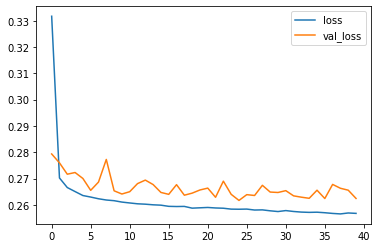

In [103]:
losses.plot()

In [104]:
from sklearn.metrics import classification_report, confusion_matrix

In [106]:
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int)
predictions

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [107]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.43      0.60     15658
           1       0.88      1.00      0.93     63386

    accuracy                           0.89     79044
   macro avg       0.94      0.71      0.77     79044
weighted avg       0.90      0.89      0.87     79044



In [108]:
df['loan_repaid'].value_counts()

1    317696
0     77523
Name: loan_repaid, dtype: int64

In [109]:
317696/len(df)
#we automatically get 80% accuracy because of the imbalanced dataset
#but the recall on our minority class is not really good with 0.43
#To Do: play around with model architecture, add more layers...

0.8038479931379817

In [110]:
print(confusion_matrix(y_test,predictions))

[[ 6720  8938]
 [    0 63386]]


## Predictions

In [129]:
#predict on random costumer
import random
random.seed(101)
#create random index
random_ind = random.randint(0,len(df))

#grab random costumer
new_customer = df.drop('loan_repaid',axis=1).iloc[random_ind]
new_customer

loan_amnt      25000.00
term              60.00
int_rate          18.24
installment      638.11
annual_inc     61665.00
                 ...   
30723              1.00
48052              0.00
70466              0.00
86630              0.00
93700              0.00
Name: 305323, Length: 78, dtype: float64

In [130]:
#needs to be numpy array to predict
#reshape to same shape as training data
new_customer.values.reshape(1,78)

array([[2.5000e+04, 6.0000e+01, 1.8240e+01, 6.3811e+02, 6.1665e+04,
        3.0110e+01, 1.9960e+03, 1.6000e+01, 0.0000e+00, 2.7778e+04,
        6.5500e+01, 4.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.00

In [131]:
#scale data
new_customer = scaler.transform(new_customer.values.reshape(1,78))
new_customer

array([[0.61538462, 1.        , 0.50331126, 0.40836493, 0.00708257,
        0.0030113 , 0.75362319, 0.2       , 0.        , 0.01593446,
        0.07340581, 0.29530201, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.  

In [132]:
pred = model.predict(new_customer)
pred = np.round(pred).astype(int)
pred

array([[1]])

In [133]:
df.iloc[random_ind]['loan_repaid']
#we predicted correctly

1.0

## Save model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save('model.h5')